In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import qutip as qt
import math as math
from qutip.qip.operations import hadamard_transform
from functools import reduce



# Grovers Algorithm 
## Introduction

Time complexity is a representation of the time taken by an algorithm to solve a problem as a function relative to the size of the input data. This property is commonly expressed in $\mathcal{O}$ ("Big O") notation which represents the upper bound of the number of steps needed to solve the problem.

If you have $N$ randomly ordered elements and you need to find a particular element, in classical computing the time complexity is $\mathcal{O}(N)$.

In the context of quantum computing, Grover's algorithm seeks to find a particular element with $\mathcal{O}(\sqrt{N})$ time complexity. The decreased time complexity is due to the superposition of states, which allows for simultaneous examination of multiple elements.

This report aims to examine Grovers Algorithm and create an executable demo using 'qutip' (Quantum Toolbox in Python)

by Jessie Lonsdale and Anastasios Mavridis.

In [2]:
def generate_search_problem(length):
    haystack = '0' * int(math.pow(2,length))
    needle = np.random.randint(0,int(math.pow(2,length))-1)
    return (haystack[:needle]+'1'+haystack[needle + 1:]), needle

In [3]:
def generate_double_search_problem(length):
    haystack = '0' * int(math.pow(2,length))
    needle1, needle2 = np.random.choice(range(int(math.pow(2,length))), size=2, replace=False)
    haystack = haystack[:needle1]+'1'+haystack[needle1+1:]
    haystack = haystack[:needle2]+'1'+haystack[needle2+1:]
    return haystack, needle1, needle2

In [4]:
def grovers_circuit(haystack,needles):
    
    state_history = []
    
    # Calculate the number of qubits needed to represent this problem
    string_length = int(len(haystack))
    number_of_qubits = int(math.log(string_length, 2))
    
    # Initialize data qubits using list comprehension
    qubits = [qt.basis(2, 0) for _ in range(number_of_qubits)]

    # Add control qubit
    qubits.append(qt.basis(2, 1))

    # Calculate tensor product of input operators to create the initial state Q:
    Q = qt.tensor(qubits)
    
    # Apply tensor product to a list of Hadamard transform operations
    H = reduce(lambda x, y: qt.tensor(x, y), [hadamard_transform(1) for _ in range(len(qubits))])
            
    ##############################
    # 1. Phase Shifting Gate, Uf #
    ##############################
    
    # Create operator that phase shifts only the target element (position of '1')
    
    Uf = np.zeros((string_length*2, string_length*2))
    for i, q in enumerate(haystack):
        Uf[2*i:2*i+2, 2*i:2*i+2] = np.array([[1, 0], [0, 1]]) if q == '0' else np.array([[0, 1], [1, 0]])
              
    ################################
    # 2. Grover Diffusion Gate, Us #
    ################################
    
    # Create the diffusion operator 2*|s><s|-I
    
    outer_product_state = (1 / (2 ** number_of_qubits)) * np.ones([2 ** number_of_qubits, 2 ** number_of_qubits])
    Us = qt.tensor(qt.Qobj(-( qt.identity(2 ** number_of_qubits)) + 2*outer_product_state), qt.qeye(2))

    #############################################
    # 3. Run the Circuit pi/4 * sqrt(N/k) times #
    #############################################
    
    # First step, applying Hadamard operator to initial state.
    # This step is only performed once, so is not included in the following loop
    
    current_state = H * Q
    state_history.append(current_state)
    
    
    for i in range(int((math.pi/4) * math.sqrt(string_length/len(needles)))):
        current_state = Uf * current_state
        current_state = Us * current_state
        current_state = qt.Qobj(current_state)
        state_history.append(current_state)
        
    return state_history


Logging results & performance from n=2 to n=10
For the problem n = 2 & haystack_size = 4
Needle position from Grover's algorithm: 1
True needle position: 1
Success! Grovers algorithm has found the correct position.
For the problem n = 3 & haystack_size = 8
Needle position from Grover's algorithm: 4
True needle position: 4
Success! Grovers algorithm has found the correct position.
For the problem n = 4 & haystack_size = 16
Needle position from Grover's algorithm: 14
True needle position: 14
Success! Grovers algorithm has found the correct position.
For the problem n = 5 & haystack_size = 32
Needle position from Grover's algorithm: 21
True needle position: 21
Success! Grovers algorithm has found the correct position.
For the problem n = 6 & haystack_size = 64
Needle position from Grover's algorithm: 47
True needle position: 47
Success! Grovers algorithm has found the correct position.
For the problem n = 7 & haystack_size = 128
Needle position from Grover's algorithm: 118
True needle pos

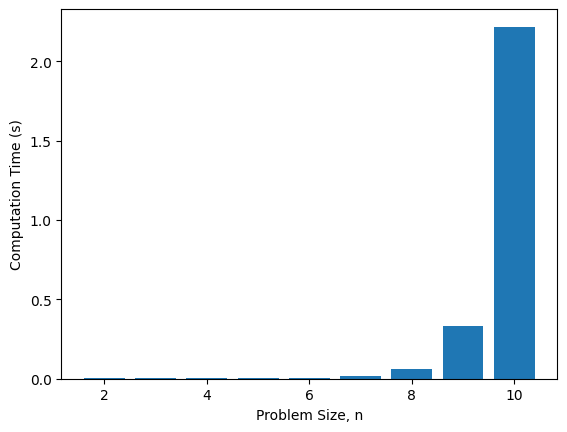

In [5]:
print("=" * 60)
print('Logging results & performance from n=2 to n=10')
computation_times = []

for n in range(2, 11):
    haystack, needle = generate_search_problem(n)
    start_time = time.time()
    current_state = np.array(grovers_circuit(haystack, [needle]).pop())
    end_time = time.time()
    result = []
    for i in range(0, len(current_state), 2):
        result.append((abs(current_state[i]) + abs(current_state[i+1]))[0])       
    needlePosFromResults = np.argmax(result)
    computation_time = end_time - start_time
    computation_times.append(computation_time)
    print("=" * 60)
    print(f"For the problem n = {n} & haystack_size = {len(haystack)}")
    print(f"Needle position from Grover's algorithm: {needlePosFromResults}")
    print(f"True needle position: {needle}")
    if needle == needlePosFromResults:
        print("Success! Grovers algorithm has found the correct position.")
    else:
        print("Failure, Grovers algorithm has found an incorrect position.")
    print("=" * 60)


plt.bar(range(2, 11), computation_times)
plt.xlabel('Problem Size, n')
plt.ylabel('Computation Time (s)')
plt.show()

In [6]:
print("=" * 60)
print('Logging results for a 2 needle problem')
for n in range(4, 12):
    haystack, needle1,needle2 = generate_double_search_problem(n)
    start_time = time.time()
    current_state = np.array(grovers_circuit(haystack, [needle1,needle2]).pop())
    end_time = time.time()
    result = []
    
    for i in range(0, len(current_state), 2):
        result.append((abs(current_state[i]) + abs(current_state[i+1]))[0])       
    sortedResults = np.argsort(result)[::-1]
    needlePos1 = sortedResults[0]
    needlePos2 = sortedResults[1]
    
    print("=" * 60)
    print(f"For the problem n = {n} & haystack_size = {len(haystack)}")
    print(f"Needle position from Grover's algorithm: {needlePos1} and {needlePos2}")
    print(f"True needle position: {needle1} and {needle2}")
    if ((needle1 == needlePos1 or needle1 == needlePos2) and (needle2 == needlePos2 or needle2 == needlePos1)):
        print("Success! Grovers algorithm has found the correct position.")
    else:
        print("Failure, Grovers algorithm has found an incorrect position.")
    print("=" * 60)

Logging results for a 2 needle problem
For the problem n = 4 & haystack_size = 16
Needle position from Grover's algorithm: 6 and 13
True needle position: 6 and 13
Success! Grovers algorithm has found the correct position.
For the problem n = 5 & haystack_size = 32
Needle position from Grover's algorithm: 28 and 20
True needle position: 28 and 20
Success! Grovers algorithm has found the correct position.
For the problem n = 6 & haystack_size = 64
Needle position from Grover's algorithm: 19 and 49
True needle position: 49 and 19
Success! Grovers algorithm has found the correct position.
For the problem n = 7 & haystack_size = 128
Needle position from Grover's algorithm: 41 and 121
True needle position: 41 and 121
Success! Grovers algorithm has found the correct position.
For the problem n = 8 & haystack_size = 256
Needle position from Grover's algorithm: 36 and 167
True needle position: 167 and 36
Success! Grovers algorithm has found the correct position.
For the problem n = 9 & haystack

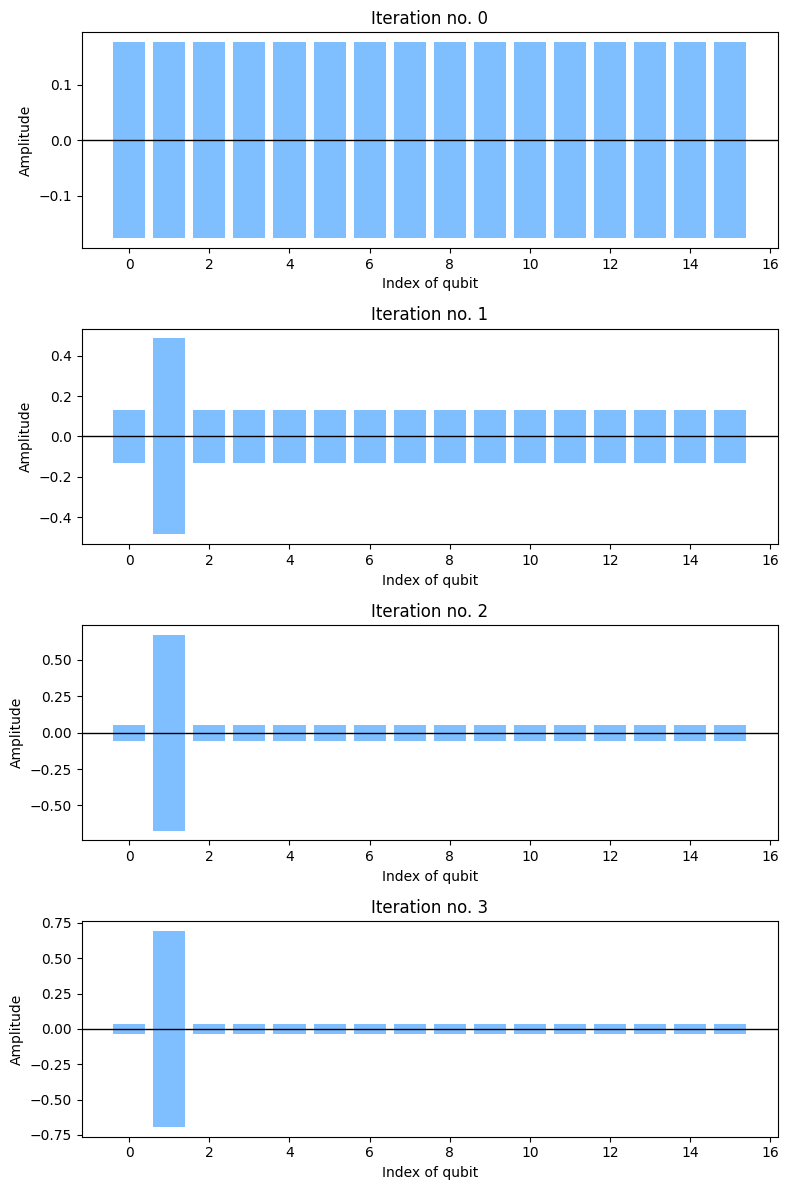

In [7]:
#Plotting how the state changes with each iteration

haystack2, needle2 = generate_search_problem(4)
state_progression = np.array(grovers_circuit(haystack2, [needle2]))

nrows = len(state_progression)
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(8, 3*nrows))

for i, data in reversed(list(enumerate(state_progression))):
    flatten_data = [[],[]]
    for j in range(0, len(data), 2):
        flatten_data[0].append(abs(data[j][0]))
        flatten_data[1].append(-abs(data[j+1][0]))
    ax = axes[i]
    ax.bar(range(len(flatten_data[0])), flatten_data[0], color='#7fbfff')
    ax.bar(range(len(flatten_data[1])), flatten_data[1], color='#7fbfff')
    ax.axhline(0, color='k', lw=1)  # Add horizontal line at y=0
    ax.set_xlabel('Index of qubit')
    ax.set_ylabel('Amplitude')
    ax.set_title('Iteration no. ' + str(i))

plt.tight_layout()
plt.show()   

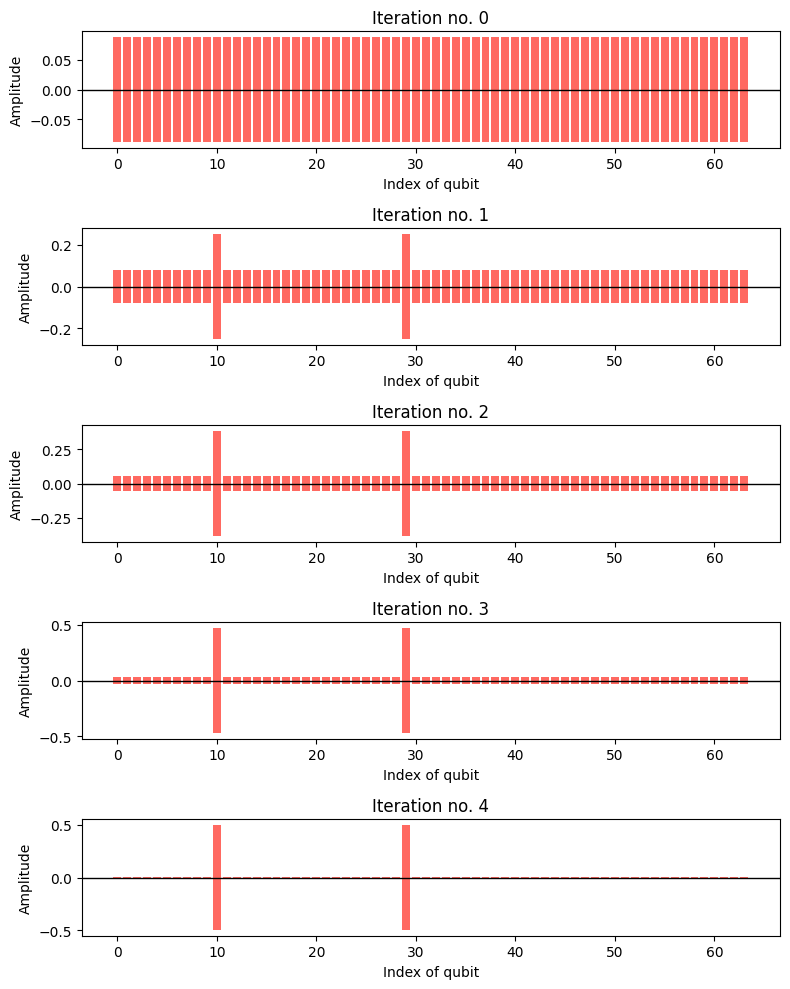

In [8]:
#Plotting how the state changes with each iteration for the DOUBLE NEEDLE PROBLEM
double_haystack, double_needle1, double_needle2 = generate_double_search_problem(6)

state_progression = np.array(grovers_circuit(double_haystack, [double_needle1, double_needle2]))

nrows = len(state_progression)
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(8, 2*nrows))

for i, data in reversed(list(enumerate(state_progression))):
    flatten_data = [[],[]]
    for j in range(0, len(data), 2):
        flatten_data[0].append(abs(data[j][0]))
        flatten_data[1].append(-abs(data[j+1][0]))
    ax = axes[i]
    ax.bar(range(len(flatten_data[0])), flatten_data[0], color='#FF6961')
    ax.bar(range(len(flatten_data[1])), flatten_data[1], color='#FF6961')
    ax.axhline(0, color='k', lw=1)  # Add horizontal line at y=0
    ax.set_xlabel('Index of qubit')
    ax.set_ylabel('Amplitude')
    ax.set_title('Iteration no. ' + str(i))

plt.tight_layout()
plt.show()  